# Main Causework UP2089158 UP2060325

## Import packages

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Settings & Load data

In [38]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # tf will show error messages only (reduce verbosity)
sns.set_style('white')

(X_train, y_train), (X_test, y_test) = cifar100.load_data()
print(X_train.shape, X_test.shape)

n_labels = len(np.unique(y_train))
n_labels

(50000, 32, 32, 3) (10000, 32, 32, 3)


100

## Workflow for data

array pointer = 60
x_train[60] shape: (32, 32, 3)
label: [36]


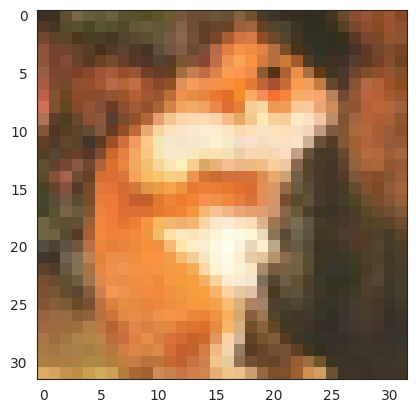

In [39]:
pointer = 60 # number of image in the dataset (remember, numbering starts from 0!)

print(f"array pointer = {pointer}")
print(f"x_train[{pointer}] shape: {X_train[pointer].shape}")
print(f"label: {y_train[pointer]}")

plt.imshow(X_train[pointer],cmap='Accent')
plt.show()

## Data preparation

In [40]:
def check_images(dataset, dataset_name):
    """
    Checks images for:
    * being an array
    * shape (28x28)
    * colour channel values
    * NaN values
    """
    invalid_count = 0  # Counter for invalid images
    valid_count = 0     # Counter for valid images

    for idx, image in enumerate(dataset):
        # Check if the image is a NumPy array
        if not isinstance(image, np.ndarray):
            print(f"{dataset_name} - Index {idx}: Not a valid image array")
            invalid_count += 1
            continue

        # Check shape (should be 28x28)
        if image.shape != (28, 28):
            print(f"{dataset_name} - Index {idx}: Incorrect shape {image.shape}")
            invalid_count += 1
            continue

        # Check if values are within expected range (0-255 for grayscale images)
        if not (image.dtype == np.uint8 and image.min() >= 0 and image.max() <= 255):
            print(f"{dataset_name} - Index {idx}: Invalid pixel values (Min: {image.min()}, Max: {image.max()})")
            invalid_count += 1
            continue

        # Check for NaN values
        if np.isnan(image).any():
            print(f"{dataset_name} - Index {idx}: Contains NaN values")
            invalid_count += 1
            continue

        valid_count += 1

    print(f"\n{dataset_name}: {valid_count} valid images, {invalid_count} invalid images")

    # Run checks on both datasets
print("Checking Images...\n")
check_images(X_train, "Train")
check_images(X_test, "Test")

Checking Images...

Train - Index 0: Incorrect shape (32, 32, 3)
Train - Index 1: Incorrect shape (32, 32, 3)
Train - Index 2: Incorrect shape (32, 32, 3)
Train - Index 3: Incorrect shape (32, 32, 3)
Train - Index 4: Incorrect shape (32, 32, 3)
Train - Index 5: Incorrect shape (32, 32, 3)
Train - Index 6: Incorrect shape (32, 32, 3)
Train - Index 7: Incorrect shape (32, 32, 3)
Train - Index 8: Incorrect shape (32, 32, 3)
Train - Index 9: Incorrect shape (32, 32, 3)
Train - Index 10: Incorrect shape (32, 32, 3)
Train - Index 11: Incorrect shape (32, 32, 3)
Train - Index 12: Incorrect shape (32, 32, 3)
Train - Index 13: Incorrect shape (32, 32, 3)
Train - Index 14: Incorrect shape (32, 32, 3)
Train - Index 15: Incorrect shape (32, 32, 3)
Train - Index 16: Incorrect shape (32, 32, 3)
Train - Index 17: Incorrect shape (32, 32, 3)
Train - Index 18: Incorrect shape (32, 32, 3)
Train - Index 19: Incorrect shape (32, 32, 3)
Train - Index 20: Incorrect shape (32, 32, 3)
Train - Index 21: Incorr

In [41]:
X_train, X_val, y_train, y_val = train_test_split(
                                    X_train,
                                    y_train,
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape)
print("* Validation set:",  X_val.shape, y_val.shape)
print("* Test set:",   X_test.shape, y_test.shape)

* Train set: (40000, 32, 32, 3) (40000, 1)
* Validation set: (10000, 32, 32, 3) (10000, 1)
* Test set: (10000, 32, 32, 3) (10000, 1)


## EDA

In [42]:
# Define class names. CIFER 100 labels
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

In [43]:
# Create a DataFrame for label frequency distribution
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

In [44]:
def count_labels(dataset, dataset_name):
    """
    Helper function to count occurrences of each label and print them
    """
    global df_freq
    unique, counts = np.unique(dataset, return_counts=True)  # Get label frequencies
    for label, frequency in zip(unique, counts):
        df_freq = pd.concat([df_freq, pd.DataFrame([{'Set': dataset_name, 'Label': class_names[label], 'Frequency': frequency}])], ignore_index=True)
        print(f"* {dataset_name} - {class_names[label]}: {frequency} images")  # Print formatted output

In [45]:
count_labels(y_train, "Train")
count_labels(y_test, "Test")
count_labels(y_val, "Validation")

* Train - apple: 377 images
* Train - aquarium_fish: 414 images
* Train - baby: 399 images
* Train - bear: 405 images
* Train - beaver: 409 images
* Train - bed: 392 images
* Train - bee: 414 images
* Train - beetle: 409 images
* Train - bicycle: 399 images
* Train - bottle: 391 images
* Train - bowl: 405 images
* Train - boy: 392 images
* Train - bridge: 400 images
* Train - bus: 403 images
* Train - butterfly: 415 images
* Train - camel: 393 images
* Train - can: 394 images
* Train - castle: 399 images
* Train - caterpillar: 394 images
* Train - cattle: 408 images
* Train - chair: 403 images
* Train - chimpanzee: 414 images
* Train - clock: 396 images
* Train - cloud: 391 images
* Train - cockroach: 391 images
* Train - couch: 395 images
* Train - crab: 401 images
* Train - crocodile: 384 images
* Train - cup: 399 images
* Train - dinosaur: 414 images
* Train - dolphin: 407 images
* Train - elephant: 404 images
* Train - flatfish: 402 images
* Train - forest: 404 images
* Train - fox

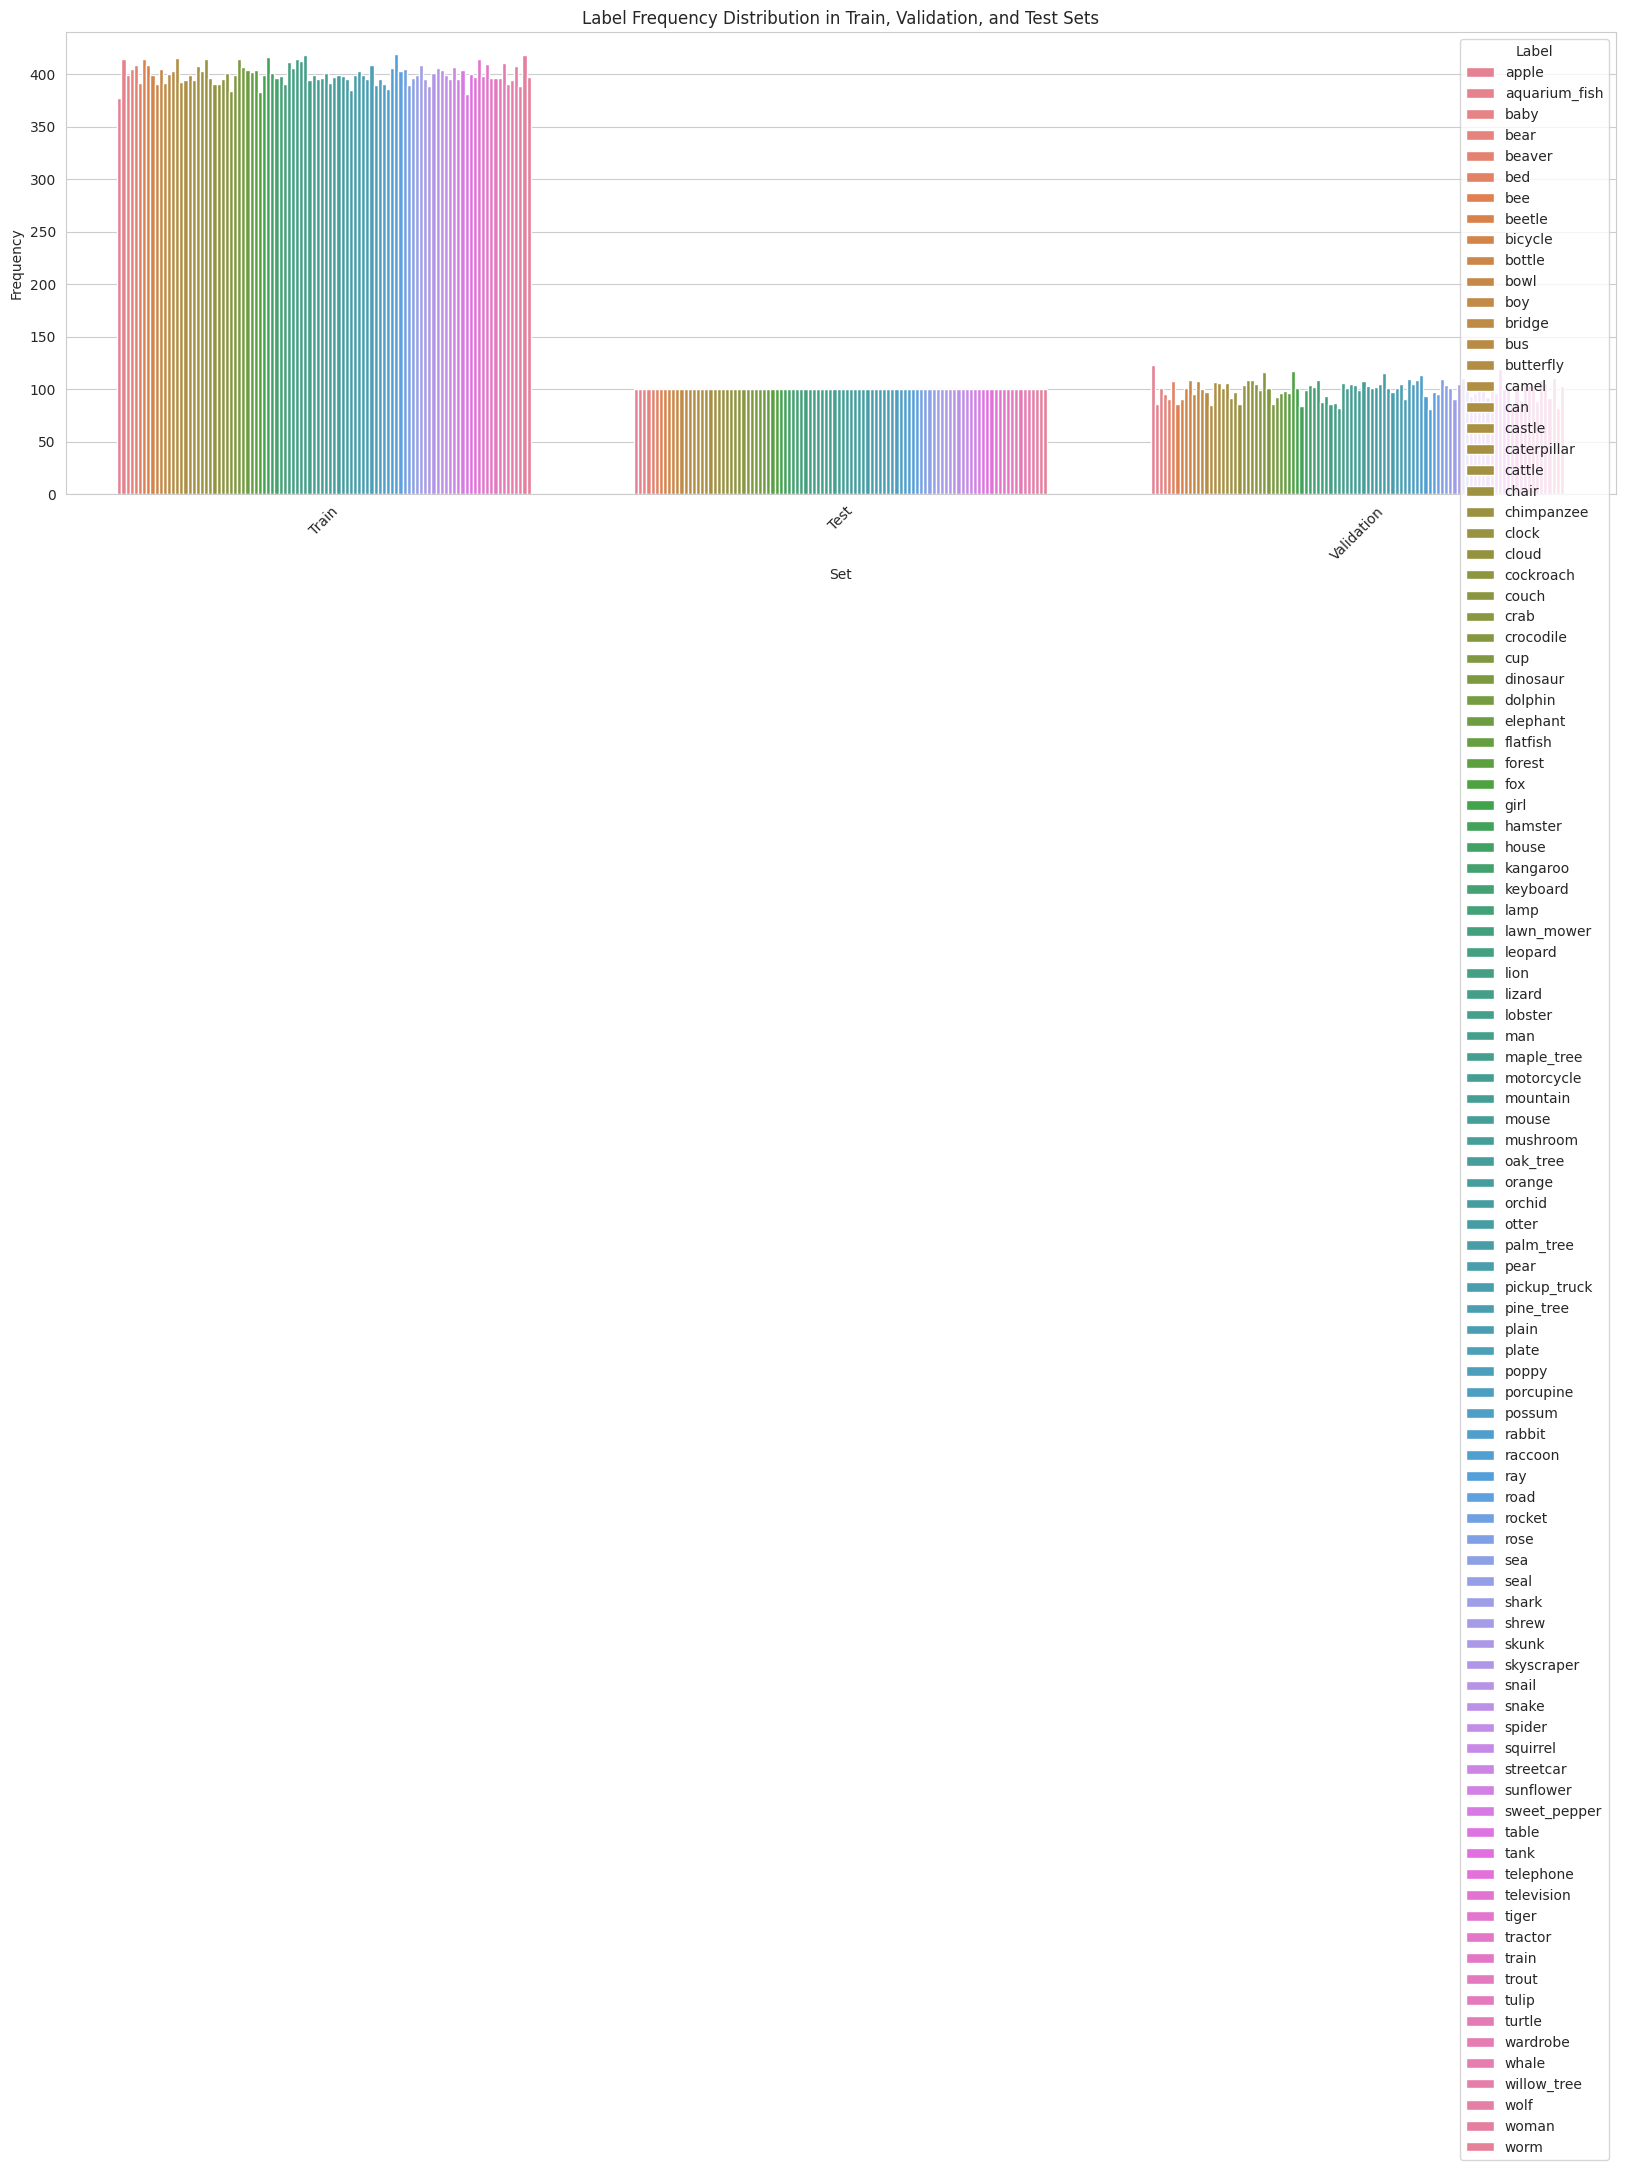

In [46]:
# Visualize the label distribution and save image
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.xticks(rotation=45)
plt.title("Label Frequency Distribution in Train, Validation, and Test Sets")
plt.show()

In [47]:
# Current data shape:
X_train.shape

(40000, 32, 32, 3)

In [48]:
# Reshape CIFER 100 data for CNN
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Check the new shape
print(X_train.shape)  # Expected output: (48000, 28, 28, 1)

(40000, 32, 32, 3)


In [49]:
X_train.max()

np.float32(1.0)

In [50]:
# **Convert labels to categorical format**
n_labels = 100  # CIFER 100 classes
y_train = to_categorical(y_train, num_classes=n_labels)
y_val = to_categorical(y_val, num_classes=n_labels)
y_test = to_categorical(y_test, num_classes=n_labels)

In [51]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Building model

In [52]:
# Model 1: Baseline CNN (Improved for First-Class Standards)
def build_tf_model(input_shape, n_labels):
  model = Sequential()

  # First Convolutional Block
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
  model.add(MaxPool2D(pool_size=(2, 2)))

  # Second Convolutional Block
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Flatten())

  # Dense Layers
  model.add(Dense(256, activation='relu'))  # Increased neurons
  model.add(Dropout(0.4))                   # Increased dropout for regularization

  # Output Layer
  model.add(Dense(n_labels, activation='softmax'))

  # Compile with lower learning rate for better convergence
  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                metrics=['accuracy'])

  return model


In [53]:
# Model 2: Deeper CNN with Batch Normalization
def build_tf_model_v2(input_shape, n_labels):
  model = Sequential()

  # First Conv Block
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))

  # Second Conv Block
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))

  model.add(Flatten())

  # Dense Layers
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))

  # Output Layer
  model.add(Dense(n_labels, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                metrics=['accuracy'])
  
  return model


In [54]:
# Model 3: Compact CNN with Larger Kernels
def build_tf_model_v3(input_shape, n_labels):
  model = Sequential()

  # First Conv Layer with 5x5 kernel
  model.add(Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=input_shape))
  model.add(MaxPool2D(pool_size=(2, 2)))

  # Second Conv Layer with 5x5 kernel
  model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Flatten())

  # Dense Layers
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))

  # Output Layer
  model.add(Dense(n_labels, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                metrics=['accuracy'])

  return model


In [55]:
model1 = build_tf_model(X_train.shape[1:], n_labels)
model2 = build_tf_model_v2(X_train.shape[1:], n_labels)
model3 = build_tf_model_v3(X_train.shape[1:], n_labels)

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Fit the model

In [56]:
# Early stopping callback (shared across all models)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

# === Model 1 Training ===
model1 = build_tf_model(input_shape=X_train.shape[1:], n_labels=n_labels)
history1 = model1.fit(x=X_train,
                      y=y_train,
                      epochs=4,
                      validation_data=(X_val, y_val),
                      verbose=1,
                      callbacks=[early_stop])

# === Model 2 Training ===
model2 = build_tf_model_v2(input_shape=X_train.shape[1:], n_labels=n_labels)
history2 = model2.fit(x=X_train,
                      y=y_train,
                      epochs=4,
                      validation_data=(X_val, y_val),
                      verbose=1,
                      callbacks=[early_stop])

# === Model 3 Training ===
model3 = build_tf_model_v3(input_shape=X_train.shape[1:], n_labels=n_labels)
history3 = model3.fit(x=X_train,
                      y=y_train,
                      epochs=4,
                      validation_data=(X_val, y_val),
                      verbose=1,
                      callbacks=[early_stop])


Epoch 1/4
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.0546 - loss: 4.2810 - val_accuracy: 0.1954 - val_loss: 3.4201
Epoch 2/4
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.1753 - loss: 3.4635 - val_accuracy: 0.2594 - val_loss: 3.0737
Epoch 3/4
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.2363 - loss: 3.1169 - val_accuracy: 0.2887 - val_loss: 2.8860
Epoch 4/4
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.2828 - loss: 2.9048 - val_accuracy: 0.3224 - val_loss: 2.7316
Restoring model weights from the end of the best epoch: 4.
Epoch 1/4
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 62ms/step - accuracy: 0.0406 - loss: 4.5363 - val_accuracy: 0.1154 - val_loss: 3.9400
Epoch 2/4
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - accuracy: 0.0969 - loss: 3.9767 - val_accuracy: 0.1871 - val_loss: 3.4574
Epoch 3/4
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - accuracy: 0.1400 - loss: 3.6475 - val_accuracy: 0.2165 - val_loss: 3.2684
Epoch 4/4
1250/1250 ━━━━

## Model evaluation

In [57]:
# Convert training histories to DataFrames
history1_df = pd.DataFrame(history1.history)
history2_df = pd.DataFrame(history2.history)
history3_df = pd.DataFrame(history3.history)

# Add model name column to each for easy comparison
history1_df['model'] = 'Model 1'
history2_df['model'] = 'Model 2'
history3_df['model'] = 'Model 3'

# Combine all histories into one DataFrame
full_history = pd.concat([history1_df, history2_df, history3_df], ignore_index=True)
full_history.head()


accuracy      loss  val_accuracy  val_loss    model
0   0.09475  3.997792        0.1954  3.420099  Model 1
1   0.19140  3.381328        0.2594  3.073711  Model 1
2   0.24425  3.082109        0.2887  2.886016  Model 1
3   0.28355  2.889270        0.3224  2.731609  Model 1
4   0.05590  4.345331        0.1154  3.940042  Model 2

## Plot accuracy and loss

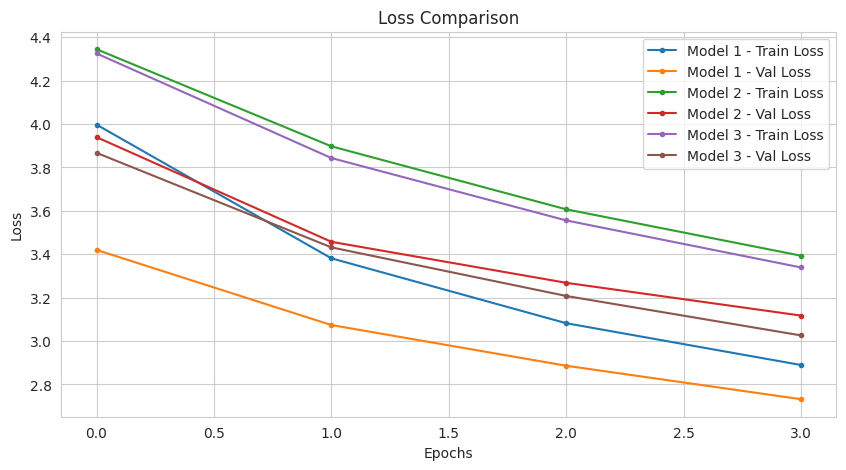

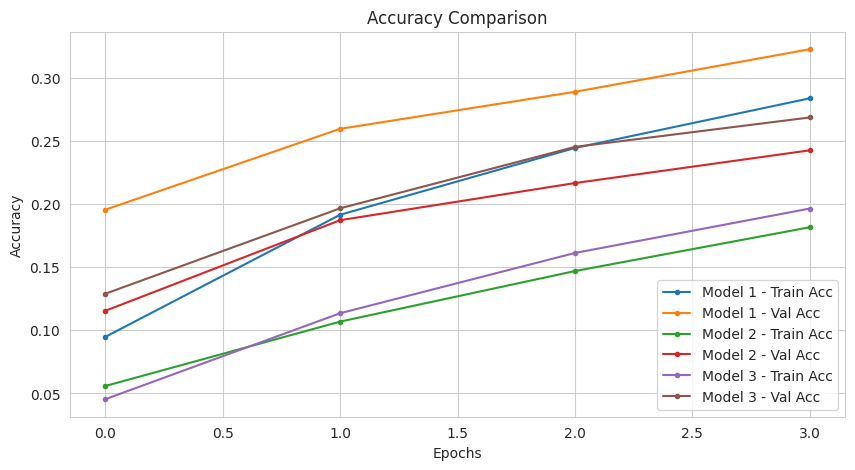

In [58]:
# Plot Loss for All Models
sns.set_style("whitegrid")

plt.figure(figsize=(10, 5))
plt.plot(history1_df['loss'], '.-', label='Model 1 - Train Loss')
plt.plot(history1_df['val_loss'], '.-', label='Model 1 - Val Loss')
plt.plot(history2_df['loss'], '.-', label='Model 2 - Train Loss')
plt.plot(history2_df['val_loss'], '.-', label='Model 2 - Val Loss')
plt.plot(history3_df['loss'], '.-', label='Model 3 - Train Loss')
plt.plot(history3_df['val_loss'], '.-', label='Model 3 - Val Loss')
plt.title("Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

print("\n")

# Plot Accuracy for All Models
plt.figure(figsize=(10, 5))
plt.plot(history1_df['accuracy'], '.-', label='Model 1 - Train Acc')
plt.plot(history1_df['val_accuracy'], '.-', label='Model 1 - Val Acc')
plt.plot(history2_df['accuracy'], '.-', label='Model 2 - Train Acc')
plt.plot(history2_df['val_accuracy'], '.-', label='Model 2 - Val Acc')
plt.plot(history3_df['accuracy'], '.-', label='Model 3 - Train Acc')
plt.plot(history3_df['val_accuracy'], '.-', label='Model 3 - Val Acc')
plt.title("Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [59]:
# Evaluate all models on the test set
test_loss1, test_acc1 = model1.evaluate(X_test, y_test, verbose=0)
test_loss2, test_acc2 = model2.evaluate(X_test, y_test, verbose=0)
test_loss3, test_acc3 = model3.evaluate(X_test, y_test, verbose=0)

# Display results
print(f"Model 1 - Test Accuracy: {test_acc1:.4f}, Loss: {test_loss1:.4f}")
print(f"Model 2 - Test Accuracy: {test_acc2:.4f}, Loss: {test_loss2:.4f}")
print(f"Model 3 - Test Accuracy: {test_acc3:.4f}, Loss: {test_loss3:.4f}")


Model 1 - Test Accuracy: 0.3311, Loss: 2.7192
Model 2 - Test Accuracy: 0.2449, Loss: 3.1270
Model 3 - Test Accuracy: 0.2781, Loss: 3.0184


In [60]:
def confusion_matrix_and_report(X, y, pipeline, label_map):
  """
  Prints the confusion matrix and classification report.
  Assumes one-hot encoded y and a trained model (pipeline).
  """
  # Make predictions (probability vectors)
  prediction = pipeline.predict(X)
  prediction = np.argmax(prediction, axis=1)
  y_true = np.argmax(y, axis=1)

  print('---  Confusion Matrix  ---')
  cm = confusion_matrix(y_true=y_true, y_pred=prediction)
  cm_df = pd.DataFrame(cm,
                       columns=[f"Predicted: {label}" for label in label_map],
                       index=[f"Actual: {label}" for label in label_map])
  print(cm_df)
  print("\n")

  print('---  Classification Report  ---')
  print(classification_report(y_true, prediction, target_names=label_map, zero_division=0))


In [61]:
def clf_performance(X_train, y_train, X_test, y_test, X_val, y_val, pipeline, label_map):
    """
    Prints classification performance (confusion matrix & report)
    for Train, Validation, and Test sets using a trained model.
    """
    print("\n" + "="*30)
    print("#### Train Set ####")
    print("="*30 + "\n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("\n" + "="*30)
    print("#### Validation Set ####")
    print("="*30 + "\n")
    confusion_matrix_and_report(X_val, y_val, pipeline, label_map)

    print("\n" + "="*30)
    print("#### Test Set ####")
    print("="*30 + "\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


In [62]:
# Classification performance for Model 1
clf_performance(X_train, y_train,
                X_test, y_test,
                X_val, y_val,
                model1,
                label_map=class_names)

# Classification performance for Model 2
clf_performance(X_train, y_train,
                X_test, y_test,
                X_val, y_val,
                model2,
                label_map=class_names)

# Classification performance for Model 3
clf_performance(X_train, y_train,
                X_test, y_test,
                X_val, y_val,
                model3,
                label_map=class_names)



#### Train Set ####

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
---  Confusion Matrix  ---
                       Predicted: apple  Predicted: aquarium_fish  \
Actual: apple                       223                         4   
Actual: aquarium_fish                 1                       225   
Actual: baby                          8                         8   
Actual: bear                          0                         1   
Actual: beaver                        0                         2   
...                                 ...                       ...   
Actual: whale                         0                         0   
Actual: willow_tree                   1                         2   
Actual: wolf                          0                         0   
Actual: woman                         3                         3   
Actual: worm                          0                         1   

                       Predicted: baby  Predicted: bear  Predicted: beaver  \
A

## Prediction

Image shape: (32, 32, 3)
One-hot label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
This is 'maple_tree'


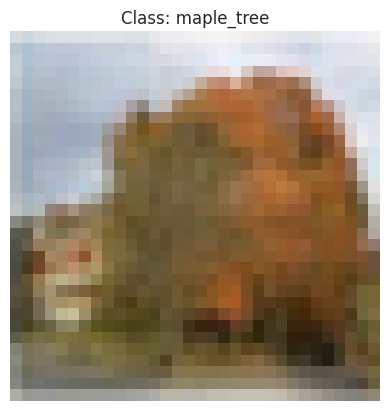


Model Predictions for Same Image:
Model 1 → Predicted: maple_tree | Confidence: 0.517
Model 2 → Predicted: willow_tree | Confidence: 0.143
Model 3 → Predicted: maple_tree | Confidence: 0.362


In [69]:
index = 102
my_garment = X_test[index]
class_index = np.argmax(y_test[index])
print("Image shape:", my_garment.shape)
print("One-hot label:", y_test[index])
print(f"This is '{class_names[class_index]}'")

sns.set_style('white')
plt.imshow(my_garment)
plt.title(f"Class: {class_names[class_index]}")
plt.axis('off')
plt.show()

live_data = np.expand_dims(my_garment, axis=0)

# Predict using each model
pred_proba1 = model1.predict(live_data, verbose=0)
pred_proba2 = model2.predict(live_data, verbose=0)
pred_proba3 = model3.predict(live_data, verbose=0)

# Get predicted class indices
pred1 = np.argmax(pred_proba1)
pred2 = np.argmax(pred_proba2)
pred3 = np.argmax(pred_proba3)

# Print results
print("\nModel Predictions for Same Image:")
print(f"Model 1 → Predicted: {class_names[pred1]} | Confidence: {pred_proba1[0][pred1]:.3f}")
print(f"Model 2 → Predicted: {class_names[pred2]} | Confidence: {pred_proba2[0][pred2]:.3f}")
print(f"Model 3 → Predicted: {class_names[pred3]} | Confidence: {pred_proba3[0][pred3]:.3f}")


In [70]:
my_garment.shape

(32, 32, 3)

In [71]:

live_data = np.expand_dims(my_garment, axis=0)
print(live_data.shape)

(1, 32, 32, 3)


In [72]:
prediction_proba_1 = model1.predict(live_data, verbose=0)
prediction_proba_2 = model2.predict(live_data, verbose=0)
prediction_proba_3 = model3.predict(live_data, verbose=0)

pred_index_1 = np.argmax(prediction_proba_1)
pred_index_2 = np.argmax(prediction_proba_2)
pred_index_3 = np.argmax(prediction_proba_3)

print(f"Model 1 Prediction: {class_names[pred_index_1]} | Confidence: {prediction_proba_1[0][pred_index_1]:.3f}")
print(f"Model 2 Prediction: {class_names[pred_index_2]} | Confidence: {prediction_proba_2[0][pred_index_2]:.3f}")
print(f"Model 3 Prediction: {class_names[pred_index_3]} | Confidence: {prediction_proba_3[0][pred_index_3]:.3f}")


Model 1 Prediction: maple_tree | Confidence: 0.517
Model 2 Prediction: willow_tree | Confidence: 0.143
Model 3 Prediction: maple_tree | Confidence: 0.362


In [74]:
# NEW: Get prediction classes for each model
prediction_class_1 = np.argmax(prediction_proba_1, axis=1)
prediction_class_2 = np.argmax(prediction_proba_2, axis=1)
prediction_class_3 = np.argmax(prediction_proba_3, axis=1)

# Print results
print(f"Model 1 predicted class: {class_names[prediction_class_1[0]]}")
print(f"Model 2 predicted class: {class_names[prediction_class_2[0]]}")
print(f"Model 3 predicted class: {class_names[prediction_class_3[0]]}")


Model 1 predicted class: maple_tree
Model 2 predicted class: willow_tree
Model 3 predicted class: maple_tree


In [76]:
prob_per_class_1 = pd.DataFrame(data=prediction_proba_1[0], columns=['Probability'])
prob_per_class_1 = prob_per_class_1.round(3)
prob_per_class_1['Results'] = class_names

prob_per_class_2 = pd.DataFrame(data=prediction_proba_2[0], columns=['Probability'])
prob_per_class_2 = prob_per_class_2.round(3)
prob_per_class_2['Results'] = class_names

prob_per_class_3 = pd.DataFrame(data=prediction_proba_3[0], columns=['Probability'])
prob_per_class_3 = prob_per_class_3.round(3)
prob_per_class_3['Results'] = class_names

print("\n Top 5 Predicted Classes per Model:")
print("\nModel 1:")
display(prob_per_class_1.sort_values(by='Probability', ascending=False).head())

print("\nModel 2:")
display(prob_per_class_2.sort_values(by='Probability', ascending=False).head())

print("\nModel 3:")
display(prob_per_class_3.sort_values(by='Probability', ascending=False).head())



 Top 5 Predicted Classes per Model:

Model 1:


Probability      Results
47        0.517   maple_tree
52        0.119     oak_tree
96        0.093  willow_tree
17        0.038       castle
32        0.027     flatfish


Model 2:


Probability      Results
96        0.143  willow_tree
47        0.100   maple_tree
17        0.083       castle
59        0.060    pine_tree
15        0.057        camel


Model 3:


Probability      Results
47        0.362   maple_tree
17        0.071       castle
96        0.055  willow_tree
15        0.051        camel
89        0.049      tractor

## Plot prediction probability for each garment in the dataset

In [77]:
fig = px.bar(
        prob_per_class,
        x = 'Results',
        y = 'Probability',
        range_y=[0,1],
        width=600, height=400,template='seaborn')
fig.update_xaxes(type='category')
fig.show()

NameError: name 'prob_per_class' is not defined